In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
im = plt.imread('img/church.jpg')

In [3]:
H,W,C = im.shape

In [4]:
im = np.mean(im,axis=2)/255

In [5]:
import math
def GaussianFilter(w,sigma):
    m = (w-1)/2
    G = []
    for i in range(w):  
        G.append(math.e**(-1*((i-m)**2/(2*sigma**2))))
    kernel = np.array(G)
    return kernel/np.sum(kernel)

In [6]:
from src.filtering import *

In [7]:
def blur(im,k,sigma=1.6):

    H,W = im.shape

    #b = 1/4
    #c = 1/4-a/2
    c,b,a,_,_=GaussianFilter(5,sigma)
   
    
    h,w = 5,5
    stride=1
    h_pad = int((H*(stride-1)-stride+h)/2)
    w_pad = int((W*(stride-1)-stride+w)/2)

    Cy = np.zeros((H,H+2*h_pad))
    Cy[np.arange(H),np.arange(H)]=c
    Cy[np.arange(H),np.arange(H)+1]=b
    Cy[np.arange(H),np.arange(H)+2]=a
    Cy[np.arange(H),np.arange(H)+3]=b
    Cy[np.arange(H),np.arange(H)+4]=c

    Cx = np.zeros((W,W+2*w_pad))
    Cx[np.arange(W),np.arange(W)]=c
    Cx[np.arange(W),np.arange(W)+1]=b
    Cx[np.arange(W),np.arange(W)+2]=a
    Cx[np.arange(W),np.arange(W)+3]=b
    Cx[np.arange(W),np.arange(W)+4]=c

    blurred_im = im
    blurred_im = np.pad(blurred_im,((h_pad,h_pad),(w_pad,w_pad)),'constant')
    for i in range(k):
        blurred_im = Cx.dot(blurred_im.T).T
        blurred_im = blurred_im.T.dot(Cy.T).T
        blurred_im = np.pad(blurred_im,((h_pad,h_pad),(w_pad,w_pad)),'constant')
    blurred_im = blurred_im[h_pad:-h_pad,w_pad:-w_pad]
    return blurred_im

In [41]:
def GaussianFilter(w,h,sigma):
    m = (w-1)/2
    n = (h-1)/2
    G = []
    for i in range(w):
        for j in range(h):
            G.append((1/(2*math.pi*sigma**2))*math.e**(-1*((i-m)**2+(j-n)**2)/(2*sigma**2)))
    
    return np.array(G).reshape(w,h)/np.sum(np.array(G))


In [117]:
def get_im2col_indices(x_shape, field_height, field_width, p_x=1,p_y=1, stride=1):
    # First figure out what the size of the output should be
    _, C, H, W = x_shape
    assert (H + 2 * p_x - field_height) % stride == 0
    assert (W + 2 * p_y - field_height) % stride == 0
    out_height = int((H + 2 * p_x - field_height) / stride + 1)
    out_width = int((W + 2 * p_y - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k, i, j)

def blur2(im,h,w,sigma=1.6,C=3):
    H,W = im.shape
    g = GaussianFilter(h,w,sigma).flatten()
    #g = np.tile(g,C)
    
    stride=1
    h_pad = int((H*(stride-1)-stride+h)/2)
    w_pad = int((W*(stride-1)-stride+w)/2)
    
    k,i,j = get_im2col_indices((1,1,H,W), h, w, p_x=h_pad,p_y=w_pad, stride=1)
    
    im_padded = np.pad(im,((h_pad,h_pad),(w_pad,w_pad)),'constant')
    cols = im_padded[i,j]

    return cols.T.dot(g).reshape(H,W)


In [57]:
im.shape

(545, 800)

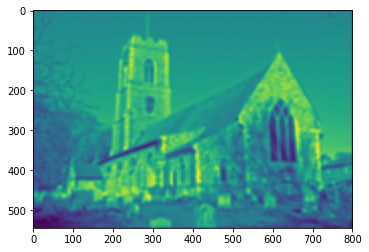

In [60]:
plt.imshow(blur2(im,11,11,sigma=5,C=3))

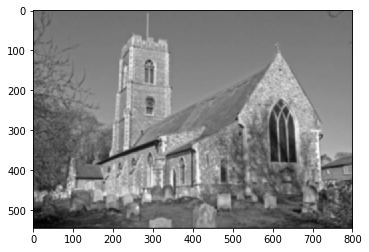

In [9]:
plt.imshow(blur(im,k=2,sigma=1.6),**{'cmap':'gray'})

In [10]:
def Reduce(im,k):   
    for j in range(k):
        H,W = im.shape

        Dx = np.zeros((int((H+H%2)/2),H))
        Dx[np.arange(int((H+H%2)/2)),np.arange(0,H,2)]=1

        Dy = np.zeros((int((W+W%2)/2),W))
        Dy[np.arange(int((W+W%2)/2)),np.arange(0,W,2)]=1
        im = (Dx.dot(im)).dot(Dy.T)
    return im

In [11]:
def Expand(im,k):       
    for j in range(k):
        H,W = im.shape
        Ex = np.zeros((2*H-H%2,H))
        Ex[np.arange(0,2*H-H%2,2,dtype=int),np.arange(H,dtype=int)]=1

        Ey = np.zeros(((2*W-W%2),W))
        Ey[np.arange(0,2*W-W%2,2,dtype=int),np.arange(W)]=1
        im = (Ex.dot(im)).dot(Ey.T)       
    return im

In [12]:
def plot_pyramid(pyramid):
    for j in range(len(pyramid)):
        octave = pyramid[j]
        plt.figure()
        N = octave.shape[2]

        for i in range(N):  
            
            plt.subplot(1,N,i+1)
            plt.title('octave '+str(j)+' scale '+str(i)+' shape '+str(octave[:,:,i].shape))
            plt.imshow(octave[:,:,i],**{'cmap':'gray'})

In [115]:
%time
def Laplacian_pyramid(im,sig=0.7,N=3,s=5,h=5,w=5):
    pyramid=[]
    img = im
    init_shape = img.shape
    #print('initial shape: {}'.format(img.shape))
    k = 2**(1/s)
    for j in range(N):
        
        if j!=0:
            img1 = Reduce(img,j)
        else:
            img1 = img
        #print('Reduced shape: {} x {}'.format(img1.shape,j)) 
        #print(im_stack.shape)
        result = []
        img1 = blur2(img1,h,w,sigma=sig) #blur(img1,k=1,sigma=sig)
        for i in range(s):
            img2 = blur2(img1,h,w,sigma=sig*k**(i+1)) #blur(img1,k=1,sigma=sig*k**(i+1))
            expanded = Expand(img2-img1,j)
            #print('Expanded shape: {}'.format(expanded.shape))           
            assert expanded.shape == init_shape
            
            result.append(expanded)
            img1 = img2
        stack = np.dstack(result)
        #stack = (stack - stack.min())/(stack - stack.min()).max()
        pyramid.append(stack)
        sig *=2
        

    return pyramid

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 µs


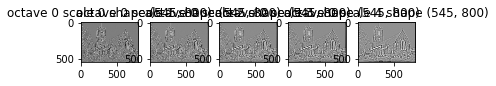

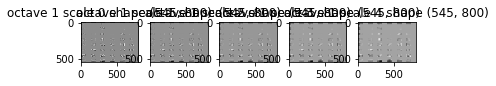

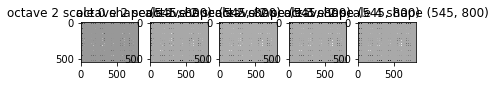

In [145]:
pyramid = Laplacian_pyramid(im,N=3,s=5,sig=1.6,h=11,w=11)
plot_pyramid(pyramid)

# Maximum

In [111]:
def get_im2col_indices(x_shape, field_height, field_width, padding=1, stride=1):
    # First figure out what the size of the output should be
    _, C, H, W = x_shape
    assert (H + 2 * padding - field_height) % stride == 0
    assert (W + 2 * padding - field_height) % stride == 0
    out_height = int((H + 2 * padding - field_height) / stride + 1)
    out_width = int((W + 2 * padding - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k, i, j)

In [153]:
def conv2d_max(f,g,k=1,**kwargs):
    w,h = g
    _,W,H = f.shape
    

    x_pad = int(0.5*((W-1)*k-W+w))
    y_pad = int(0.5*((H-1)*k-H+w))

    f_pad = np.pad(f,((0,0),(x_pad,x_pad),(y_pad,y_pad)),mode='constant')

    I=[]
    for m in range(int(f_pad.shape[2]-w)+1):
        
        for n in range(int(f_pad.shape[1]-h+1)):
            
            w = f_pad[:,n:n+11,m:m+11]
           
            w_max = w[1,5,5]
            w[1,5,5]=0
            
            if (np.max(w)< w_max)|(np.min(w)>w_max)==True:
                I.append(1)
            else:
                I.append(0)

    return np.array(I).reshape(H,W)

kps={1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:{}}

s=5
for o in range(3):

    for st in range(s-3):
        cols = pyramid[o][st:st+3,:,:]
        print(cols.shape)
        kp = conv2d_max(cols,(11,11))
        kps[st+1].append(np.argwhere(kp))
        


(3, 800, 5)
(3, 800, 5)
(3, 800, 5)
(3, 800, 5)
(3, 800, 5)
(3, 800, 5)


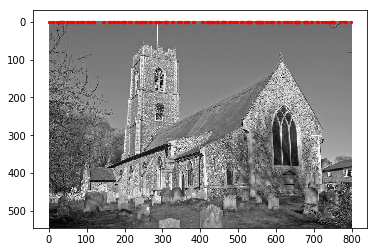

In [154]:
AA = np.vstack(kps[1])
plt.imshow(im,**{'cmap':'gray'})
plt.scatter(AA[:,1],AA[:,0],s=5,color='red')

In [155]:
C = 3
N=2
s=5
H,W = im.shape
k,i,j = get_im2col_indices((1,3,H,W), 11, 11, padding=5, stride=1)

kps={1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:{}}

for o in range(N):
    im_padded = np.pad(np.moveaxis(pyramid[o][:,:,:],2,0),((0,0),(5,5),(5,5)),'constant')
    
    
    for st in range(s-3):
        cols = im_padded[st:st+3,:,:]
        plt.imshow(cols[1,:,:])
        plt.show()
        
        cols = cols[k,i,j]
        print(cols.shape)
        cols = np.delete(cols,115,0)

        kp = np.argwhere((pyramid[o][:,:,st+1].flatten() > np.max(cols,axis=0)).reshape(H,W))
        print(kp)
        
        kps[st+1].append(kp)


TypeError: get_im2col_indices() got an unexpected keyword argument 'padding'

In [32]:
kps

{1: [array([], shape=(0, 2), dtype=int64),
  array([], shape=(0, 2), dtype=int64),
  array([], shape=(0, 2), dtype=int64)],
 2: [array([], shape=(0, 2), dtype=int64),
  array([], shape=(0, 2), dtype=int64),
  array([], shape=(0, 2), dtype=int64)],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: {}}

In [50]:
AA = np.vstack(kps[1])
AA

array([], shape=(0, 2), dtype=int64)

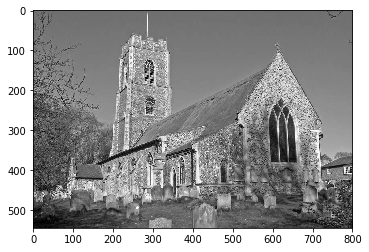

In [36]:
plt.imshow(im,**{'cmap':'gray'})
plt.scatter(AA[:,1],AA[:,0],s=5,color='red')

In [107]:
C = 3
N=3
s=5
H,W = im.shape
k,i,j = get_im2col_indices((1,3,H,W), 3, 3, padding=1, stride=1)

kps={1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[]}

for n in range(N):
    im_padded = np.pad(np.moveaxis(pyramid[n][:,:,:],2,0),((0,0),(1,1),(1,1)),'constant')
    
    for st in range(s-3):
       
        cols = im_padded[st:st+3,:,:][k,i,j]
        
        cols = np.delete(cols,14,0)
        
        kp = np.argwhere((pyramid[n][:,:,st+1].flatten() > np.max(cols,axis=0)).reshape(H,W))
        
        kps[st+1].append(kp)
print(kps)

{1: [array([], shape=(0, 2), dtype=int64), array([], shape=(0, 2), dtype=int64), array([], shape=(0, 2), dtype=int64)], 2: [array([], shape=(0, 2), dtype=int64), array([], shape=(0, 2), dtype=int64), array([], shape=(0, 2), dtype=int64)], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}


In [96]:
kps[1]=np.vstack(kps[1])
kps[2]=np.vstack(kps[2])

TypeError: list indices must be integers or slices, not tuple

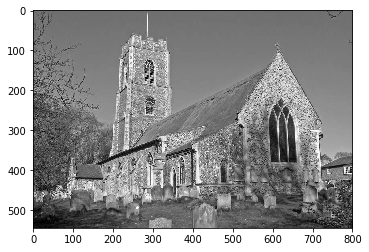

In [145]:
kp.shape
plt.imshow(im,**{'cmap':'gray'})
plt.scatter(kps[1][:,1],kps[1][:,0],s=0.5,color='red')

TypeError: list indices must be integers or slices, not tuple

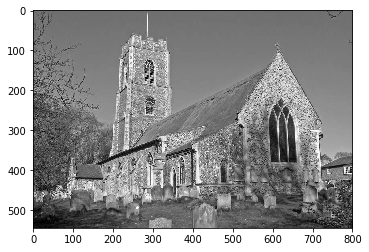

In [69]:
kp.shape
plt.imshow(im,**{'cmap':'gray'})
plt.scatter(kps[2][:,1],kps[2][:,0],s=1,color='red')

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.05572139, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

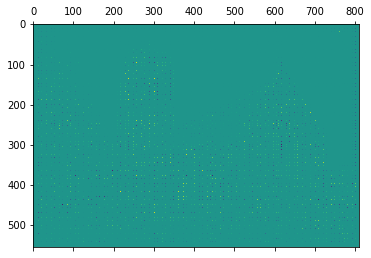

In [146]:
plt.matshow(im_padded[0,:,:])
im_padded[0,100:104,100:104]

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.01884844, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

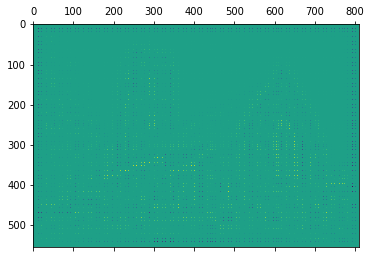

In [147]:
plt.matshow(im_padded[1,:,:])
im_padded[1,100:104,100:104]

array([[0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.003684, 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      ]])

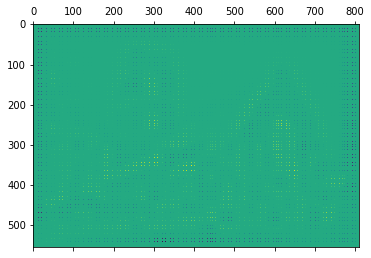

In [148]:
plt.matshow(im_padded[2,:,:])
im_padded[2,100:104,100:104]